Deepfake Manipulation Detection

#### Imports

In [1]:
import cv2
import os
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

2024-06-13 18:27:12.059572: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-13 18:27:12.060778: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 18:27:12.116542: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 18:27:12.324617: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 18:27:13.005277: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

#### FaceLandmarker 

In [2]:
BaseOptions = mp.tasks.BaseOptions
FaceLandmarker = mp.tasks.vision.FaceLandmarker
FaceLandmarkerOptions = mp.tasks.vision.FaceLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

In [3]:
# create a facelandmarker from options
options = FaceLandmarkerOptions(
    base_options = BaseOptions(model_asset_path='./models/face_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO,
    output_face_blendshapes=True,
    output_facial_transformation_matrixes=True,
    num_faces=1
)

In [87]:
def process_video(video_path, label, options):
    cap = cv2.VideoCapture(video_path)

    transformation_matrices = []
    timestamps = []
    frame_count = 0

    with FaceLandmarker.create_from_options(options) as face_landmarker:

        while cap.isOpened():
            ret, frame = cap.read()

            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

            frame_timestamp = int(cap.get(cv2.CAP_PROP_POS_MSEC))

            face_landmarker_result = face_landmarker.detect_for_video(mp_image, frame_timestamp)

            if face_landmarker_result.facial_transformation_matrixes:
                for matrix in face_landmarker_result.facial_transformation_matrixes:
                    transformation_matrices.append(matrix.flatten())
                    timestamps.append(frame_timestamp)

            frame_count += 1  # Increment frame counter

            if frame_count > 9 :  # Check if frame limit is reached (10 frames taken)
                break
        cap.release()

    return np.array(transformation_matrices), np.array(timestamps), label

In [58]:
# path to video files
originals = './data/face_forensics++/originals'
deepfakes = './data/face_forensics++/deepfakes'
test_originals = './data/face_forensics++/test_originals'
test_deepfakes = './data/face_forensics++/test_deepfakes'

In [59]:
def load_data(originals, deepfakes, options):
    X = []
    y = []


    for video_path in os.listdir(originals):
        matrices, timestamps, label = process_video(video_path=os.path.join(originals, video_path), label=0, options=options)
        if matrices.size == 0:
            continue 
        # matrices = matrices[:50]
        timestamps = timestamps.reshape(-1,1)
        
        combined = np.hstack((matrices, timestamps/1000.0))
        # print(matrices.shape, timestamps.shape)
        X.append(combined)
        # label_list = [label] * combined.shape[0]
        y.append(1)
    
    print("ORIGINALS DONEEEEE")

    for video_path in os.listdir(deepfakes):

        matrices, timestamps, label = process_video(video_path= os.path.join(deepfakes, video_path), label=1, options=options)
        if matrices.size == 0:
            continue 
        timestamps = timestamps.reshape(-1,1)
        print(video_path)
        combined = np.hstack((matrices, timestamps/ 1000.0))
        X.append(combined)
        # label_list = [label] * combined.shape[0]
        y.append(0) 
    
        # Pad sequences to ensure all have the same length
    X_padded = pad_sequences(X, padding='post', dtype='float32')

    # Convert lists to numpy arrays
    y = np.array(y).reshape(-1, 1)  # Ensure y is in the correct shape (number_of_samples, 1)

    return X_padded, y



In [ ]:
# Load data
X, y = load_data(originals, deepfakes, options)

In [80]:
# Xnp = np.array(X)
# ynp = np.array(y)
print(X.shape, y.shape)
# print(y)

(1930, 15, 17) (1930, 1)


In [53]:
print(len(X[0][1]), len(y))

17 1909


In [10]:
print(ynp)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [81]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [13]:
# Define the LSTM model
model = Sequential()
# model.add(Masking(mask_value=0.0, input_shape=(Xnp.shape[1], Xnp.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [83]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5270 - loss: 0.6933 - val_accuracy: 0.4725 - val_loss: 0.7087
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4885 - loss: 0.6999 - val_accuracy: 0.4563 - val_loss: 0.6990
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5001 - loss: 0.6904 - val_accuracy: 0.5437 - val_loss: 0.6908
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4920 - loss: 0.6914 - val_accuracy: 0.4693 - val_loss: 0.6942
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5151 - loss: 0.6871 - val_accuracy: 0.5405 - val_loss: 0.6929
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5484 - loss: 0.6869 - val_accuracy: 0.4466 - val_loss: 0.6957
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5393 - loss: 0.6873 - val_accuracy: 0.4369 - val_loss: 0.6973
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5429 - loss: 0.6811 - val_accuracy: 0.5113 - val_loss:

In [84]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_acc}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5193 - loss: 0.6959 
Test Accuracy: 0.5259067416191101


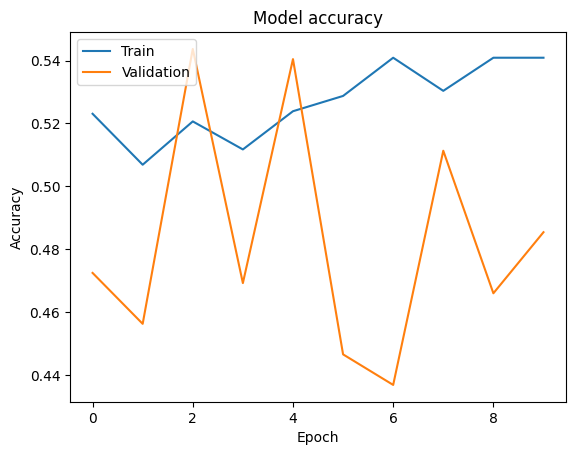

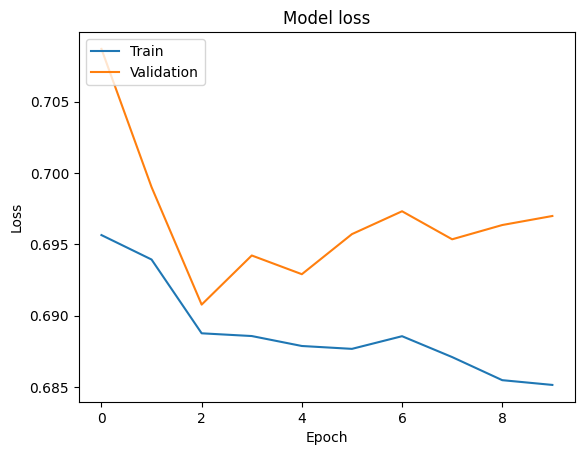

In [85]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()